#### Running Simulation with three phase charging system

In [1]:
# Necessary imports
import pytz
from datetime import datetime
import numpy as np
# import cvxpy as cp
from copy import deepcopy
import time 
from matplotlib import pyplot as plt
from matplotlib import cm

from acnportal import acnsim
from acnportal.acnsim import analysis
from acnportal import algorithms
import adacharge

#### Pre-defined Caltech ACN Network (single phase)

*Assume nominal voltage in the network*

In [2]:
# Extracted from the source code

def single_phase_caltech_acn(basic_evse=False, voltage=208, transformer_cap=150, network_type=acnsim.ChargingNetwork):
    """ Predefined single phase ChargingNetwork for the Caltech ACN.

    Args:
        basic_evse (bool): If True use BASIC EVSE type instead of actual AeroViroment and ClipperCreek types.
        voltage (float): Default voltage at the EVSEs. Does not affect the current rating of the transformer which is
            based on nominal voltages in the network. 277V LL for delta primary and 120V LN for wye secondary. [V]
        transformer_cap (float): Capacity of the transformer in the CaltechACN. Default: 150. [kW]

    Attributes:
        See ChargingNetwork class for Attributes.
    """
    network = network_type()

    if basic_evse:
        evse_type = {'AV': 'BASIC', 'CC': 'BASIC'}
    else:
        evse_type = {'AV': 'AeroVironment', 'CC': 'ClipperCreek'}
        
    # Define the sets of EVSEs in the Caltech ACN.
    CC_pod_ids = ["CA-322", "CA-493", "CA-496", "CA-320", "CA-495", "CA-321", "CA-323", "CA-494"]
    AV_pod_ids = ["CA-324", "CA-325","CA-326","CA-327","CA-489", "CA-490", "CA-491", "CA-492"]
    other_ids = [f"CA-{id_num}" for id_num in [148, 149, 212, 213, 303, 304, 305, 306, 307, 308,
                                               309, 310, 311, 312, 313, 314, 315, 316, 317, 318,
                                               319, 497, 498, 499, 500, 501, 502, 503, 504, 505,
                                               506, 507, 508, 509, 510, 511, 512, 513]]
    all_ids = CC_pod_ids + AV_pod_ids + other_ids

    # Add Caltech EVSEs
    for evse_id in all_ids:
        if evse_id not in CC_pod_ids:
            network.register_evse(acnsim.get_evse_by_type(evse_id, evse_type['AV']), voltage, 0)
        else:
            network.register_evse(acnsim.get_evse_by_type(evse_id, evse_type['CC']), voltage, 0)
            
    # Add Caltech Constraint Set
    CC_pod = acnsim.Current(CC_pod_ids)
    AV_pod = acnsim.Current(AV_pod_ids)
    all_current = acnsim.Current(all_ids)

    # Build constraint set
    network.add_constraint(CC_pod, 80, name='CC Pod')
    network.add_constraint(AV_pod, 80, name='AV Pod')
    network.add_constraint(all_current, transformer_cap * 1000 / voltage, name='Transformer Cap')
    return network

#### Simulation Setup

In [4]:
def experiment(algorithm):
    """ Run single phase vs. three phase experiment for a particular algorithm. """
    # -- Experiment Parameters ---------------------------------------------------
    timezone = pytz.timezone('America/Los_Angeles')
    start = timezone.localize(datetime(2018, 9, 5))
    end = timezone.localize(datetime(2018, 9, 6))
    period = 5  # minute
    voltage = 208  # volts
    default_battery_power = 32 * voltage / 1000 # kW
    site = 'caltech'

    # -- Network -------------------------------------------------------------------
    single_phase_cn = single_phase_caltech_acn(basic_evse=True, transformer_cap=70)
    real_cn = acnsim.sites.caltech_acn(basic_evse=True, transformer_cap=70)

    # -- Events ---------------------------------------------------------------------
    API_KEY = 'DEMO_TOKEN'
    events = acnsim.acndata_events.generate_events(API_KEY, site, start, end, period, 
                                                   voltage, default_battery_power)
    
    # -- Single Phase ----------------------------------------------------------------
    single_phase_sim = acnsim.Simulator(deepcopy(single_phase_cn), algorithm, 
                                        deepcopy(events), start, period=period, 
                                        verbose=False)
    single_phase_sim.run()
    
    # Since we are interested in how the single-phase LLF algorithm would have performed 
    # in the real CaltechACN, we replace the network model with the real network model 
    # for analysis. 
    single_phase_sim.network = real_cn
    
    # -- Three Phase -----------------------------------------------------------------        
    three_phase_sim = acnsim.Simulator(deepcopy(real_cn), algorithm,
                                       deepcopy(events), start, period=period, 
                                       verbose=False)
    three_phase_sim.run()
    
    return single_phase_sim, three_phase_sim

#### Running Simulation

##### Least Laxity First

In [5]:
llf = algorithms.SortedSchedulingAlgo(algorithms.least_laxity_first)
llf_sp_sim, llf_tp_sim = experiment(llf)

##### Model Predictive Control

In [6]:
quick_charge_obj = [adacharge.ObjectiveComponent(adacharge.quick_charge),
                    adacharge.ObjectiveComponent(adacharge.equal_share, 1e-12)]
mpc = adacharge.AdaptiveSchedulingAlgorithm(quick_charge_obj, solver="MOSEK")
mpc_sp_sim, mpc_tp_sim = experiment(mpc)

##### Results
In order to compare the single-phase and three-phase versions of LLF, we plot the aggregate power of all EVSEs as well as individual line currents on the primary and secondary side of the transformer

In [9]:
def plot_currents(single_phase_sim, three_phase_sim, transfomer_cap):
    cmap = cm.get_cmap('tab20c')

    fig, axes = plt.subplots(3, 2, sharey='row', sharex=True, figsize=(6,4))
    fig.subplots_adjust(wspace=0.17, hspace=0.17)
    axes[0, 0].set_xlim(7*12, 17*12)
    
    for i in range(3):
        for j in range(2):
            axes[i, j].spines['right'].set_visible(False)
            axes[i, j].spines['top'].set_visible(False)

    # Plot Aggregate Charging Power
    sp_agg = analysis.aggregate_current(single_phase_sim)*208/1000
    tp_agg = analysis.aggregate_current(three_phase_sim)*208/1000
    sp_color = 4
    tp_color = 0
    axes[0, 0].plot(sp_agg, color=cmap(sp_color))
    axes[0, 1].plot(tp_agg, color=cmap(tp_color))


    # Calculate currents in constrained lines
    sp_cc = analysis.constraint_currents(single_phase_sim)
    tp_cc = analysis.constraint_currents(three_phase_sim)

    # Plot currents in lines on the Primary and Secondary side of the transformer.
    for j, line in enumerate('ABC'): 
        axes[1, 0].plot(sp_cc['Primary {0}'.format(line)], label='Primary {0}'.format(line), color=cmap(j + sp_color))
        axes[1, 1].plot(tp_cc['Primary {0}'.format(line)], label='Primary {0}'.format(line), color=cmap(j + tp_color))

        axes[2, 0].plot(sp_cc['Secondary {0}'.format(line)], label='Secondary {0}'.format(line), color=cmap(j + sp_color))
        axes[2, 1].plot(tp_cc['Secondary {0}'.format(line)], label='Secondary {0}'.format(line), color=cmap(j + tp_color))

    # Plot limits 
    axes[0, 0].axhline(transfomer_cap, color='k', linestyle='--')
    axes[1, 0].axhline(transfomer_cap*1000/277/3, color='k', linestyle='--')
    axes[2, 0].axhline(transfomer_cap*1000/120/3, color='k', linestyle='--')

    axes[0, 1].axhline(transfomer_cap, color='k', linestyle='--')
    axes[1, 1].axhline(transfomer_cap*1000/277/3, color='k', linestyle='--')
    axes[2, 1].axhline(transfomer_cap*1000/120/3, color='k', linestyle='--')

    axes[0, 0].set_title("Single Phase Constraints")
    axes[0, 1].set_title("Three Phase Constriants")
    
    fig.text(0.015, 0.77, 'Aggregate\nPower (kW)', va='center', rotation='vertical')
    fig.text(0.015, 0.37, 'Line Currents (A)', va='center', rotation='vertical')
    fig.text(0.04, 0.50, 'Secondary', va='center', rotation='vertical')
    fig.text(0.04, 0.24, 'Primary', va='center', rotation='vertical')
        
    plt.xticks(range(7*12, 17*12, 36), ['7:00', '10:00', '13:00', '16:00'])
    plt.show()
    return fig

##### Result: Least Laxity First

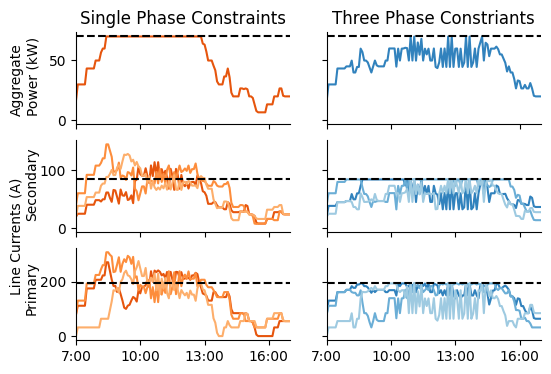

In [10]:
llf_fig = plot_currents(llf_sp_sim, llf_tp_sim, 70)

In [11]:
llf_fig.savefig(f"C:\\Users\s3955218\\OneDrive - RMIT University\\Research Milestones\\CoC\simulation_others\\llf_single_v_three_phase.tiff", dpi=300)

##### Result: Model Predictive Control

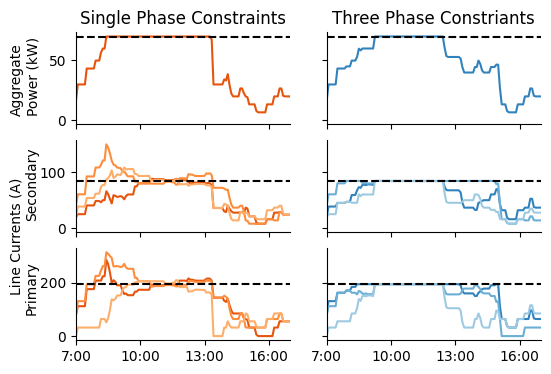

In [12]:
mpc_fig = plot_currents(mpc_sp_sim, mpc_tp_sim, 70)

In [13]:
mpc_fig.savefig(f"C:\\Users\s3955218\\OneDrive - RMIT University\\Research Milestones\\CoC\simulation_others\\mpc_single_v_three_phase.tiff", dpi=300)

In case of single-phase constraints both LLF and MPC shows significant constraint violations in line currents. However, by designing an algorithm which considers the full three-phase model, we are able to respect these constraints. Note that because of phase unbalance, we are not able to make use of the full 70 kW transformer capacity while also respecting line limits using LLF. MPC allows us to fully utilize the capacity but still takes longer to deliver the same amount of energy due to contraints from phase imbalances. PV and BSS effect hasn't been considered for above simulation. 